🌊 Connecting to Satellite Database...
✅ Found 1 satellite scenes!
🛰️ Analyzing Scene from: 2024-01-31 10:22:51.024000+00:00
💾 Saved masked river map: Pra_Masked_2024-01-31.png


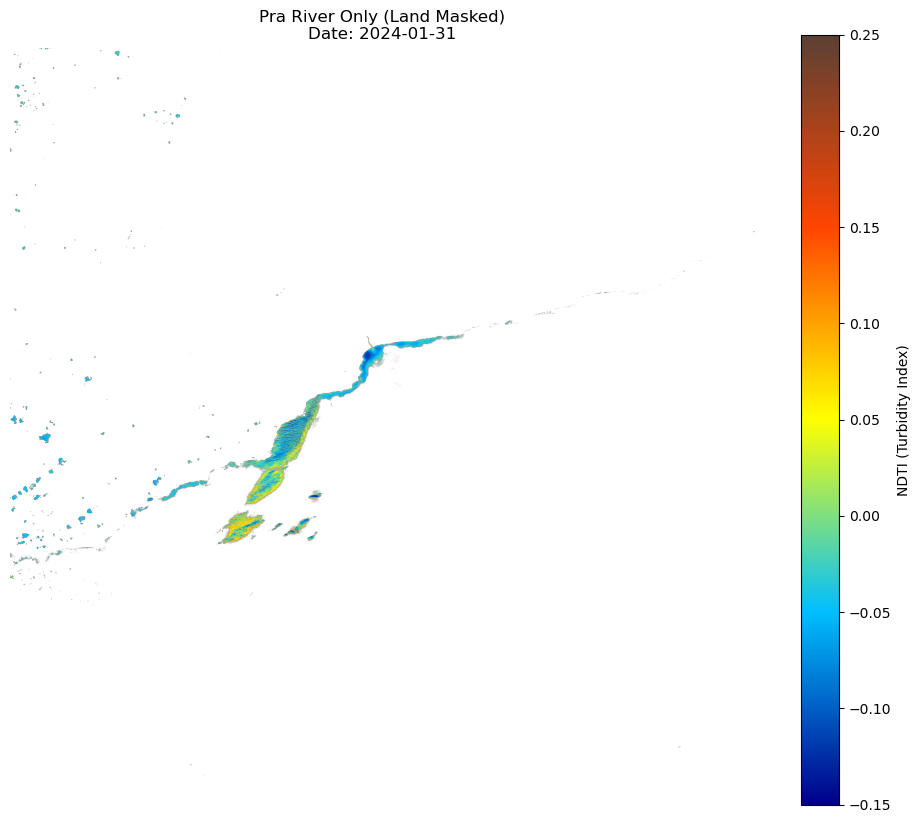

In [1]:
import pystac_client
import planetary_computer
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from rasterio.io import MemoryFile

# --- Define our Area (Pra River Galamsey Hotspot) ---
# Coordinates: [min_lon, min_lat, max_lon, max_lat]
AOI_BBOX = [-1.62, 5.05, -1.55, 5.15] 
DATE_RANGE = "2024-01-01/2024-03-30" # Looking at early 2024

print("🌊 Connecting to Satellite Database...")

# Find Sentinel-2 Images ---
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)

# We just ask for the images, we don't ask it to sort them
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=AOI_BBOX,
    datetime=DATE_RANGE,
    query={"eo:cloud_cover": {"lt": 10}}, 
)

# Get all the items
items = search.item_collection()

# We sort them right here using standard Python
# This sorts the list by date, putting the newest one first (Reverse=True)
items = sorted(items, key=lambda item: item.properties["datetime"], reverse=True)

print(f"✅ Found {len(items)} satellite scenes!")

if len(items) > 0:
    selected_item = items[0]
    print(f"🛰️ Analyzing Scene from: {selected_item.datetime}")

# ---Stream Red, Green AND Near-Infrared (NIR) ---
    href_red = selected_item.assets["B04"].href
    href_green = selected_item.assets["B03"].href
    href_nir = selected_item.assets["B08"].href  # <--- NEW: NIR Band for Water Masking

    with rasterio.open(href_red) as src:
        red = src.read(1, out_shape=(src.height // 2, src.width // 2)) 
        profile = src.profile # Save metadata for later

    with rasterio.open(href_green) as src:
        green = src.read(1, out_shape=(src.height // 2, src.width // 2))

    with rasterio.open(href_nir) as src:
        nir = src.read(1, out_shape=(src.height // 2, src.width // 2))

    # CALC: Turbidity (NDTI) AND Water Mask (NDWI) ---
    np.seterr(divide='ignore', invalid='ignore')
    
    # Cast to float for math
    r = red.astype(float)
    g = green.astype(float)
    n = nir.astype(float)

    # Turbidity Index (Red - Green) / (Red + Green)
    ndti = (r - g) / (r + g)
    
    # Water Index (Green - NIR) / (Green + NIR)
    ndwi = (g - n) / (g + n)

    # VISUALIZE The Masked Map ---
    plt.figure(figsize=(12, 10))
    
    # Create the Galamsey colormap
    colors = ["#00008b", "#00BFFF", "#FFFF00", "#FF4500", "#5c4033"]
    cmap = mcolors.LinearSegmentedColormap.from_list("galamsey", colors)
    
    # CREATE THE MASK
    # Threshold: NDWI > 0 usually means water. 
    # We create a "masked array" where anything NOT water (NDWI < 0) is hidden.
    masked_ndti = np.ma.masked_where(ndwi < 0.0, ndti)
    
    # Plotting
    # We set the background to 'white' or 'grey' so the river stands out
    plt.imshow(masked_ndti, cmap=cmap, vmin=-0.15, vmax=0.25)
    
    plt.colorbar(label="NDTI (Turbidity Index)")
    
    date_str = selected_item.datetime.strftime("%Y-%m-%d")
    plt.title(f"Pra River Only (Land Masked)\nDate: {date_str}")
    plt.axis('off')
    
    filename = f"Pra_Masked_{date_str}.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"💾 Saved masked river map: {filename}")
    
    plt.show()